In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [2]:
semester = 'S19'
BASE_PATH = os.path.join('data', 'Release', semester)
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join(BASE_PATH, 'Test')

In [3]:
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data'))


In [4]:
train_ps2

In [5]:
early_train = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,04c32d4d95425f73b3a1d6502aed4d48,439.0,1,1,True,True
1,04c32d4d95425f73b3a1d6502aed4d48,439.0,3,2,True,True
2,04c32d4d95425f73b3a1d6502aed4d48,439.0,5,3,True,True
3,04c32d4d95425f73b3a1d6502aed4d48,439.0,12,1,True,True
4,04c32d4d95425f73b3a1d6502aed4d48,439.0,13,2,True,True


In [6]:
late_train = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))
late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,04c32d4d95425f73b3a1d6502aed4d48,494.0,41,False
1,04c32d4d95425f73b3a1d6502aed4d48,494.0,43,True
2,04c32d4d95425f73b3a1d6502aed4d48,494.0,44,True
3,04c32d4d95425f73b3a1d6502aed4d48,494.0,46,True
4,04c32d4d95425f73b3a1d6502aed4d48,494.0,49,True


In [7]:
X_train_base = late_train.copy().drop('Label', axis=1)
y_train = late_train['Label'].values

In [8]:
problem_encoder = OneHotEncoder().fit(X_train_base[PS2.ProblemID].values.reshape(-1, 1))


In [9]:
problem_encoder.transform(X_train_base[PS2.ProblemID].values.reshape(-1, 1)).toarray()


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Task 1

In [10]:
def extract_instance_features(instance, early_df):
    instance = instance.copy()
    subject_id = instance[PS2.SubjectID]
    early_problems = early_df[early_df[PS2.SubjectID] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    instance = instance.drop('SubjectID')
    return instance

In [11]:
extract_instance_features(X_train_base.iloc[0], early_train)


AssignmentID                  494
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually           1
MedAttempts                   6.5
MaxAttempts                    45
PercCorrectFirstTry      0.166667
Name: 0, dtype: object

In [12]:
def extract_features(X, early_df, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, problem_ids], axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, scaler, True)

In [14]:
print(X_train.shape)
X_train[:2,]

(4201, 25)


array([[ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

# Evaluate the Training Performance of the Model

In [15]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(y_train, train_predictions))
print('AUC: ' + str(roc_auc_score(y_train, train_predictions)))
print('Macro F1: ' + str(f1_score(y_train, train_predictions, average='macro')))

              precision    recall  f1-score   support

       False       0.59      0.27      0.37      1084
        True       0.79      0.93      0.85      3117

    accuracy                           0.76      4201
   macro avg       0.69      0.60      0.61      4201
weighted avg       0.73      0.76      0.73      4201

AUC: 0.6011804980898702
Macro F1: 0.6108309893517259


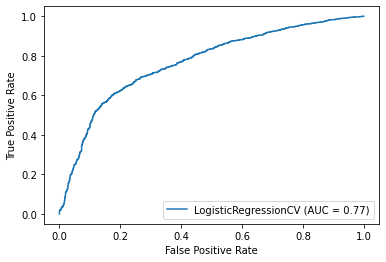

In [17]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

In [18]:
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7545814953059609
AUC: 0.7567641472064508
Macro F1: 0.5925332201513649


In [77]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=1000)

In [78]:
train_predictions_rf = rf.predict(X_train)

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(y_train, train_predictions_rf))
print('AUC: ' + str(roc_auc_score(y_train, train_predictions_rf)))
print('Macro F1: ' + str(f1_score(y_train, train_predictions_rf, average='macro')))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1084
        True       0.99      1.00      1.00      3117

    accuracy                           0.99      4201
   macro avg       1.00      0.99      0.99      4201
weighted avg       0.99      0.99      0.99      4201

AUC: 0.9889298892988929
Macro F1: 0.9924854395329202


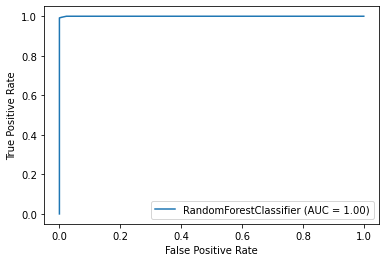

In [22]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf, X_train, y_train)

In [102]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,activation = 'relu',learning_rate='invscaling',
                    hidden_layer_sizes=(300,150), random_state=1)

mlp.fit(X_train, y_train)

C:\Users\tanma\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(300, 150),
              learning_rate='invscaling', random_state=1, solver='lbfgs')

In [103]:
train_predictions_mlp = mlp.predict(X_train)

In [104]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(y_train, train_predictions_mlp))
print('AUC: ' + str(roc_auc_score(y_train, train_predictions_mlp)))
print('Macro F1: ' + str(f1_score(y_train, train_predictions_mlp, average='macro')))

              precision    recall  f1-score   support

       False       0.94      0.88      0.91      1084
        True       0.96      0.98      0.97      3117

    accuracy                           0.96      4201
   macro avg       0.95      0.93      0.94      4201
weighted avg       0.96      0.96      0.96      4201

AUC: 0.9315151585105841
Macro F1: 0.9411810115138954


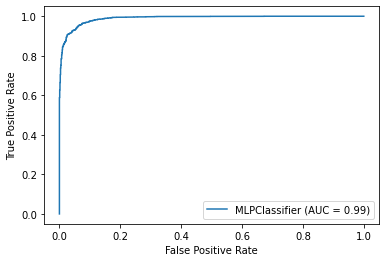

In [105]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(mlp, X_train, y_train)

In [118]:
from sklearn import datasets
import xgboost as xgb

In [119]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

C:\Users\tanma\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, v

In [120]:
print(grid.best_params_)

{'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 3}


In [124]:
param = {
    'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 3,
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [122]:
D_train = xgb.DMatrix(X_train, label=y_train)
#D_test = xgb.DMatrix(X_test, label=y_test)

In [125]:
model = xgb.train(param, D_train, steps)

[21:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Predict on test data S19

In [52]:
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [53]:
X_test.shape

(1511, 25)

In [54]:
predictions = mlp.predict_proba(X_test)[:,1]


In [55]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,0.000071
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,0.000013
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,0.000668
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,0.000342
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,0.001987
...,...,...,...,...
1506,fc5f86251458722c799d1830fa0c2c1f,494.0,67,0.949489
1507,fc5f86251458722c799d1830fa0c2c1f,494.0,104,0.333692
1508,fc5f86251458722c799d1830fa0c2c1f,494.0,106,0.998412
1509,fc5f86251458722c799d1830fa0c2c1f,494.0,107,0.043257


In [56]:
path = os.path.join('data', 'Prediction', semester, 'basic_LR_task1', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

# Predict on the test data (F19)

In [126]:
F19_TEST_PATH = os.path.join('data', 'Release', 'F19', 'Test')


In [127]:
early_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [128]:
X_test.shape


(2365, 25)

In [129]:
predictions = model.predict_proba(X_test)[:,1]


AttributeError: 'Booster' object has no attribute 'predict_proba'

In [116]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.915333
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.588000
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.902000
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.632000
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.910000
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.409000
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.156000
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.778000
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.690000


In [117]:
path = os.path.join('data', 'Prediction', 'F19', 'basic_LR_task1', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

# Task 2

In [23]:
train_base = train_ps2.load_link_table('Subject')
train_base

,SubjectID,X-Grade
0,65be44ae7088566069cc3bef454174a7,0.3600
1,f4db8537e9d75da46c4efc36a2d70956,0.4310
2,e3edca0f6e68bfb76eaf26a8eb6dd94b,0.8400
3,d843407a1a701630bb297c1148229eff,0.4900
4,d0a17b281c3e4eaef6718d891e38cb42,0.3400
...,...,...
242,4a914e5c38172ae9b61780ffbd0b2f90,0.8244
243,ffb72475a81de0e95b910ffad039f5c2,0.6817
244,40195594f1244e7ec627b1c6a5a35585,0.7029
245,e2d083a5fd066b082d93042169313e21,0.6800


In [24]:
train_base = late_train.groupby('SubjectID')['Label'].sum().to_frame('X-Grade').reset_index()
train_base['X-Grade'] = train_base['X-Grade'] / 20
train_base

,SubjectID,X-Grade
0,04c32d4d95425f73b3a1d6502aed4d48,0.55
1,0503bf609757acf2e75aa8cbc0d8323b,0.45
2,06d801cb636235b298c40029ad9921e7,0.90
3,07ae4cca3f90a49347ccb5c1a82ff46f,0.95
4,07d34e2419c61216a85a2156b2cf8ae4,0.75
...,...,...
241,f827b5406c7aa5b4fe10062ae06a137b,0.80
242,f892447540d0e840049183faa3109b1b,0.90
243,fda6baab618b39821b678bd52ff26428,0.15
244,feae21bb32b7b4aa690fab151b60b598,1.00


In [25]:
y_train = train_base['X-Grade']


In [26]:
# The base of our X dataset is just a set of SubjectIDs
X_train_base = train_base.drop('X-Grade', axis=1)

In [27]:
from sklearn.preprocessing import StandardScaler
X_train_unscaled = X_train_base.apply(lambda row: extract_instance_features(row, early_train), axis=1)

In [28]:
X_train_unscaled


,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry
0,30,1.000000,6.5,45,0.166667
1,21,1.000000,2.0,11,0.476190
2,20,1.000000,2.0,31,0.350000
3,30,0.966667,1.0,21,0.733333
4,30,1.000000,1.0,12,0.600000
...,...,...,...,...,...
241,30,1.000000,1.0,7,0.533333
242,30,0.966667,1.0,14,0.666667
243,29,0.655172,4.0,22,0.172414
244,30,0.966667,1.0,9,0.933333


In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_train

array([[ 0.55944356,  0.60104733,  1.73417818,  1.78407068, -0.88773091],
       [-1.11888712,  0.60104733, -0.48645253, -0.62386335,  0.39482508],
       [-1.30536831,  0.60104733, -0.48645253,  0.79256843, -0.12806313],
       ...,
       [ 0.37296237, -2.04668342,  0.50049446,  0.15517413, -0.86391688],
       [ 0.55944356,  0.34510002, -0.97992602, -0.76550653,  2.28906163],
       [-1.30536831,  0.60104733, -0.48645253,  0.58010367,  0.07911899]])

In [30]:
X_train_unscaled.join(train_base).drop(PS2.SubjectID, axis=1).corr()


,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry,X-Grade
ProblemsAttempted,1.000000,0.284741,-0.196953,0.131532,0.135139,0.318915
PercCorrectEventually,0.284741,1.000000,-0.343506,-0.069976,0.337193,0.432099
MedAttempts,-0.196953,-0.343506,1.000000,0.669611,-0.781536,-0.458429
MaxAttempts,0.131532,-0.069976,0.669611,1.000000,-0.574600,-0.259660
PercCorrectFirstTry,0.135139,0.337193,-0.781536,-0.574600,1.000000,0.451771
X-Grade,0.318915,0.432099,-0.458429,-0.259660,0.451771,1.000000


# Evaluate the Training Performance of the Model

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

model = LassoCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

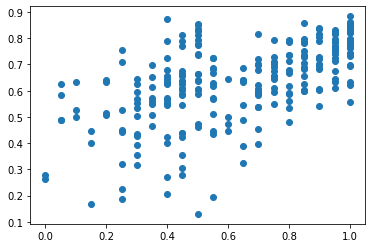

In [32]:
plt.scatter(y_train, train_predictions)


In [33]:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Training MSE: ' + str(mean_squared_error(y_train, train_predictions)))
print('Training R2: ' + str(r2_score(y_train, train_predictions)))

Training MSE: 0.048443143030792175
Training R2: 0.3419949456061411


# Evaluate the CV Performance of the Model

In [34]:
from sklearn.model_selection import cross_validate

model = LassoCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['neg_mean_squared_error', 'r2'])
print(f'MSE: {-np.mean(cv_results["test_neg_mean_squared_error"])}')
print(f'R2: {np.mean(cv_results["test_r2"])}')

MSE: 0.050437248898341905
R2: 0.2792971411405756


# Predict on the test data (S19)

In [35]:
test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

# The Subject.csv link table is just the SubjectIDs to be predicted
X_test_base = test_ps2.load_link_table('Subject')
X_test_unscaled = X_test_base.apply(lambda row: extract_instance_features(row, early_test), axis=1)
X_test_unscaled

,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry
0,19,0.421053,4.0,35,0.210526
1,19,0.789474,5.0,41,0.157895
2,24,0.916667,2.5,29,0.291667
3,17,0.764706,2.0,77,0.352941
4,30,1.000000,3.0,41,0.300000
...,...,...,...,...,...
78,30,0.966667,3.0,44,0.300000
79,30,1.000000,1.0,4,0.766667
80,20,1.000000,1.0,10,0.650000
81,20,1.000000,1.0,4,0.650000


In [36]:
X_test = scaler.transform(X_test_unscaled)


In [37]:
X_test.shape


(83, 5)

In [38]:
model = LassoCV()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [39]:
predictions


array([ 2.25210773e-01,  3.81428547e-01,  5.82786728e-01,  4.10956312e-01,
        6.64174706e-01,  6.15620613e-01,  5.91372031e-01,  7.81499333e-01,
        6.14208739e-01,  7.42456756e-01, -1.00441829e-01,  7.06688698e-01,
        8.25546781e-01,  4.65928547e-01,  7.64090294e-01,  6.76188458e-01,
        7.49631140e-01,  7.81860473e-01,  7.24074988e-01,  6.16245391e-01,
        7.78524312e-01,  6.08201863e-01, -3.48426295e-01,  8.38756458e-01,
        5.50283756e-01,  7.27688089e-01,  7.74100420e-04,  5.60165847e-01,
        6.32946519e-01,  5.90343327e-01,  8.22904483e-01,  5.10591476e-01,
        7.30022913e-01,  4.29984394e-01,  8.00882247e-01,  6.80623584e-01,
        5.89676162e-01,  5.31832586e-01,  6.39217575e-01,  6.25798903e-01,
        6.27982633e-01,  6.81292007e-01,  5.55844944e-01,  6.54567488e-01,
        6.81596314e-01,  6.91398778e-01,  7.90704426e-01,  7.24103405e-01,
        8.27577490e-01,  3.62362656e-01,  6.16329162e-01,  6.62812420e-01,
        7.36447372e-01,  

In [40]:
predictions_df = X_test_base.copy()
predictions_df['X-Grade'] = predictions
predictions_df

,SubjectID,X-Grade
0,0bdf2c1f053650715e1f0c725d754b96,0.225211
1,d7419ae04f248e5105ac3d0700389775,0.381429
2,81a0c4689fb7ce553a0d5c2fd19b6efd,0.582787
3,468cbac056133a996283cca7e2976336,0.410956
4,e4191d610537305de1d294adb121b513,0.664175
...,...,...
78,cb03474483e366b5c8dd9f4a2a7537c1,0.643791
79,cc70903297fe1e25537ae50aea186306,0.838756
80,29b2cd4a11745fefecc14912d2f95dd8,0.711921
81,700fe688ff2970d633ff04c9b7f7cdd4,0.717928


In [41]:
# We use res/predictions.csv, since that's where the scoring rogram expects it
# but you can change this directory
path = os.path.join('data', 'Prediction', semester, 'basic_LR_task2', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

# Predict on the test data (F19)

In [1]:

import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

s19_early_train=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/S19_Release_6_28_21.zip/Train/early.csv')

s19_late_train=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/S19_Release_6_28_21.zip/Train/late.csv')

s19_early_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/S19_Release_6_28_21.zip/Test/early.csv')

s19_late_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/S19_Release_6_28_21.zip/Test/late.csv')

f19_early_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/F19_Release_Test_06-28-21/Test/early.csv')

f19_late_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/F19_Release_Test_06-28-21/Test/late.csv')


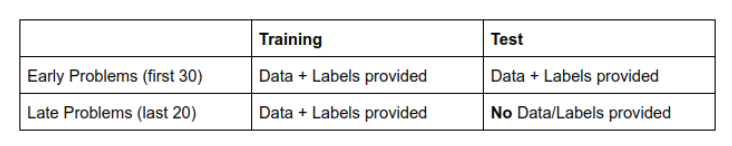

In [24]:
s19_early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,04c32d4d95425f73b3a1d6502aed4d48,439.0,1,1,True,True
1,04c32d4d95425f73b3a1d6502aed4d48,439.0,3,2,True,True
2,04c32d4d95425f73b3a1d6502aed4d48,439.0,5,3,True,True
3,04c32d4d95425f73b3a1d6502aed4d48,439.0,12,1,True,True
4,04c32d4d95425f73b3a1d6502aed4d48,439.0,13,2,True,True


In [26]:
s19_early_test.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,False


In [28]:
s19_late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,04c32d4d95425f73b3a1d6502aed4d48,494.0,41,False
1,04c32d4d95425f73b3a1d6502aed4d48,494.0,43,True
2,04c32d4d95425f73b3a1d6502aed4d48,494.0,44,True
3,04c32d4d95425f73b3a1d6502aed4d48,494.0,46,True
4,04c32d4d95425f73b3a1d6502aed4d48,494.0,49,True


In [27]:
s19_late_test.head()

,SubjectID,AssignmentID,ProblemID
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49


In [32]:
def extract_instance_features(instance, s19_early_train):
    instance = instance.copy()
    subject_id = instance[s19_early_train.SubjectID]
    early_problems = early_df[s19_early_train['SubjectID'] == subject_id]
    instance['ProblemsAttempted'] = early_problems.shape[0]
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    instance = instance.drop('SubjectID')
    return instance

In [30]:
X_train_base = s19_late_train.copy().drop('Label', axis=1)
y_train = s19_late_train['Label'].values

In [34]:
#extract_instance_features(X_train_base.iloc[0], s19_early_train)


# Track 2

In [45]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
from os import path

In [46]:
semester = 'S19'
PATH = "data/CodeWorkout/" + semester

In [47]:
data = ProgSnap2Dataset(PATH)

In [49]:
# Drop the attempt column, since it's calculated incorrectly
data.drop_main_table_column('Attempt')

In [50]:
main_table = data.get_main_table()
student_table = data.load_link_table('Subject')

In [51]:
main_table.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,TermID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
0,0,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,1804399,True,Run.Program,1.0,NaN,NaN,NaN,32-84779,NaN,NaN
1,1,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,1804399,True,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN
2,2,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,1805146,True,Run.Program,1.0,NaN,NaN,NaN,32-84781,NaN,NaN
3,3,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,1805146,True,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN
4,4,13499,Java 8; CodeWorkout,2019-03-20T21:13:09,0,CS 1114,410.0,spring-2019,492.0,32,1805216,True,Run.Program,0.0,NaN,NaN,NaN,32-84783,NaN,NaN


Fall 2019 Preprocessing
There were some differences between F19 and S19:

In F19 there was an additional assignment (between Assignment 4 and 5), which only ~70% of students completed, likely additional optional practice. We will not use this assignment for prediction, since it is abnormal and not in S19. Since it comes in between the two assignments we are using for prediction, we simply remove it.
In F19 the AssignmentIDs were renamed, so we will update their names
In F19 2 ProblemIDs were renamed (though the solutions were unchanged), so we will update their names

In [52]:
print(len(main_table[PS2.AssignmentID].unique()))
print(len(main_table[PS2.ProblemID].unique()))

5
50


In [53]:

# This assignment has no analogue, but we use 500 to put it between the other 2
NEW_F19_ASSIGNMENT = 500

In [54]:
if semester == 'F19':
    assignment_map = {
        597: 439,
        600: 487,
        609: 492,
        615: 494,
        622: NEW_F19_ASSIGNMENT,
        631: 502,
    }
    print(np.mean(main_table[PS2.AssignmentID].isin(assignment_map)))
    main_table[PS2.AssignmentID] = main_table[PS2.AssignmentID].map(assignment_map)
    
    # Two problems were renamed but are equivalent
    problem_map = {problem_id: problem_id for problem_id in main_table[PS2.ProblemID].unique()}
    problem_map[736] = 45
    problem_map[737] = 48
    print(np.mean(main_table[PS2.ProblemID].isin(problem_map)))
    main_table[PS2.ProblemID] = main_table[PS2.ProblemID].map(problem_map, na_action='ignore')
    
    # Overwrite the main table so this is the one that's copied
    data.set_main_table(main_table)

In [55]:
print(len(main_table[PS2.AssignmentID].unique()))
print(len(main_table[PS2.ProblemID].unique()))

5
50


In [56]:
main_table[PS2.ProblemID]


0         32
1         32
2         32
3         32
4         32
          ..
201565    20
201566    20
201567    20
201568    20
201569    20
Name: ProblemID, Length: 201570, dtype: int64

# Filtering Students

Here we remove studens who did not take the final exam, since we cannot use these for Task 2 (final exam score prediction). While this does somewhat bias the dataset for Task 1, it also ensures a consistent set of training/testing students for both tasks.

We can also see that few students are actually removed this way (381 -> 348 for S19).

In [57]:

# Get the SubjectIDs where the final grade is non-0
# A 0 grade indicates the student did not take the final
print(len(student_table.index))
subject_ids = set(student_table[student_table['X-Grade'] != 0][PS2.SubjectID].unique())
subject_ids = subject_ids.intersection(set(student_table['SubjectID'].unique()))
len(subject_ids)

381


348

# EDA

We want to confirm that our selected students have a good and well-distributed number of attempts at all the problems in the dataset, and the most problems were well-attempted. The stats and figures below suggest that this is the case: most problems are attempted by ~300/350 students, and most students complete ~40/50 problems.

In [58]:
# First we check how many problems each student attempted
main_table_filtered = main_table[main_table[PS2.SubjectID].isin(subject_ids)]
problems_per_student = main_table_filtered.groupby(by=['SubjectID']).apply(lambda rows: len(rows[PS2.ProblemID].unique()))
# 75% of problems were attempted by at least 40 studens, so that's good
problems_per_student.describe()

count    346.000000
mean      42.855491
std       10.331712
min        1.000000
25%       40.000000
50%       48.500000
75%       50.000000
max       50.000000
dtype: float64

In [59]:
# Only 3 attempted fewer than 10 problems
sum(problems_per_student < 10)

3

In [60]:
# Next we see how many students attempted each problem
students_per_problem = main_table_filtered.groupby(by=['AssignmentID', 'ProblemID']).apply(lambda rows: len(rows[PS2.SubjectID].unique()))
students_per_problem.describe()

count     50.000000
mean     296.560000
std       14.642906
min      267.000000
25%      285.000000
50%      295.500000
75%      309.750000
max      324.000000
dtype: float64

<BarContainer object of 50 artists>

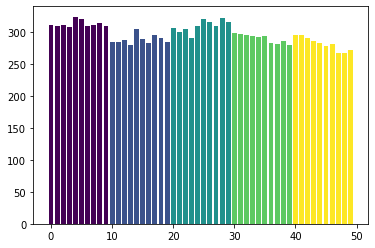

In [61]:
# Next we plot the number of attemptes on each problem (x) / assignment (color)
from matplotlib.cm import viridis

assignment_ids = list(students_per_problem.keys().map(lambda x: x[0]))
assignment_ids = [sorted(assignment_ids).index(x) for x in assignment_ids]
colors = [viridis((float(i)-min(assignment_ids))/(max(assignment_ids)-min(assignment_ids))) for i in assignment_ids]

# There's a slight drop-off by assignment, but overall they're well-attempted
plt.bar(range(0, len(students_per_problem)), students_per_problem, color=colors)

In [39]:
train_base = train_ps2.load_link_table('Subject')
train_base

,SubjectID,X-Grade
0,14302,0.3600
1,9948,0.3917
2,14303,0.0000
3,7349,0.6160
4,9217,0.4310
...,...,...
376,13654,0.6800
377,10309,0.0000
378,10311,0.0000
379,14204,0.9200


In [44]:
def get_start_end_order(rows):
    return pd.Series({
        'StartEventOrder': min(rows[PS2.Order])
        # 'EndEventOrder': max(rows[PS2.Order])
    })

start_orders = main_table_filtered.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(get_start_end_order)
start_orders

NameError: name 'main_table_filtered' is not defined

In [40]:
train_base = .groupby('SubjectID')['Label'].sum().to_frame('X-Grade').reset_index()
train_base['X-Grade'] = train_base['X-Grade'] / 20
train_base

,SubjectID,X-Grade
0,04c32d4d95425f73b3a1d6502aed4d48,0.55
1,0503bf609757acf2e75aa8cbc0d8323b,0.45
2,06d801cb636235b298c40029ad9921e7,0.90
3,07ae4cca3f90a49347ccb5c1a82ff46f,0.95
4,07d34e2419c61216a85a2156b2cf8ae4,0.75
...,...,...
241,f827b5406c7aa5b4fe10062ae06a137b,0.80
242,f892447540d0e840049183faa3109b1b,0.90
243,fda6baab618b39821b678bd52ff26428,0.15
244,feae21bb32b7b4aa690fab151b60b598,1.00


In [2]:
df=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/CodeWorkout/CodeWorkout/MainTable.csv')
df

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,TermID,AssignmentID,ProblemID,...,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
0,0,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,1804399,True,Run.Program,1.000000,NaN,NaN,NaN,32-84779,NaN,NaN
1,1,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,1804399,True,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN
2,2,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,1805146,True,Run.Program,1.000000,NaN,NaN,NaN,32-84781,NaN,NaN
3,3,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,1805146,True,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN
4,4,13499,Java 8; CodeWorkout,2019-03-20T21:13:09,0,CS 1114,410.0,spring-2019,492.0,32,...,1805216,True,Run.Program,0.000000,NaN,NaN,NaN,32-84783,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201565,201565,14236,Java 8; CodeWorkout,2019-03-09T04:57:22,0,CS 1114,407.0,spring-2019,487.0,20,...,1790842,True,Compile,NaN,Success,NaN,NaN,20-14497,20-14496,NaN
201566,201566,14236,Java 8; CodeWorkout,2019-03-09T04:58:06,0,CS 1114,407.0,spring-2019,487.0,20,...,1790851,True,Run.Program,0.785714,NaN,NaN,NaN,20-14498,NaN,NaN
201567,201567,14236,Java 8; CodeWorkout,2019-03-09T04:58:06,0,CS 1114,407.0,spring-2019,487.0,20,...,1790851,True,Compile,NaN,Success,NaN,NaN,20-14499,20-14498,NaN
201568,201568,14236,Java 8; CodeWorkout,2019-03-09T04:58:39,0,CS 1114,407.0,spring-2019,487.0,20,...,1790858,True,Run.Program,1.000000,NaN,NaN,NaN,20-14500,NaN,NaN


In [3]:
df_code=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/CodeWorkout/CodeWorkout/LinkTables/CodeStates.csv')
df_code

,CodeStateID,Code
0,1804399,"public String plusOut(String str, String word)..."
1,1805146,"public String plusOut(String str, String word)..."
2,1805216,"public String plusOut(String str, String word)..."
3,1805218,"public String plusOut(String str, String word)..."
4,1805219,"public String plusOut(String str, String word)..."
...,...,...
69622,1790797,"public int loneSum(int a, int b, int c)\r\n{\r..."
69623,1790837,"public int loneSum(int a, int b, int c)\r\n{\r..."
69624,1790842,"public int loneSum(int a, int b, int c)\r\n{\r..."
69625,1790851,"public int loneSum(int a, int b, int c)\r\n{\r..."


In [4]:
df = pd.merge(df, df_code, how="left", on="CodeStateID")
df

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,TermID,AssignmentID,ProblemID,...,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation,Code
0,0,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,True,Run.Program,1.000000,NaN,NaN,NaN,32-84779,NaN,NaN,"public String plusOut(String str, String word)..."
1,1,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,True,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN,"public String plusOut(String str, String word)..."
2,2,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,True,Run.Program,1.000000,NaN,NaN,NaN,32-84781,NaN,NaN,"public String plusOut(String str, String word)..."
3,3,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,True,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN,"public String plusOut(String str, String word)..."
4,4,13499,Java 8; CodeWorkout,2019-03-20T21:13:09,0,CS 1114,410.0,spring-2019,492.0,32,...,True,Run.Program,0.000000,NaN,NaN,NaN,32-84783,NaN,NaN,"public String plusOut(String str, String word)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201565,201565,14236,Java 8; CodeWorkout,2019-03-09T04:57:22,0,CS 1114,407.0,spring-2019,487.0,20,...,True,Compile,NaN,Success,NaN,NaN,20-14497,20-14496,NaN,"public int loneSum(int a, int b, int c)\r\n{\r..."
201566,201566,14236,Java 8; CodeWorkout,2019-03-09T04:58:06,0,CS 1114,407.0,spring-2019,487.0,20,...,True,Run.Program,0.785714,NaN,NaN,NaN,20-14498,NaN,NaN,"public int loneSum(int a, int b, int c)\r\n{\r..."
201567,201567,14236,Java 8; CodeWorkout,2019-03-09T04:58:06,0,CS 1114,407.0,spring-2019,487.0,20,...,True,Compile,NaN,Success,NaN,NaN,20-14499,20-14498,NaN,"public int loneSum(int a, int b, int c)\r\n{\r..."
201568,201568,14236,Java 8; CodeWorkout,2019-03-09T04:58:39,0,CS 1114,407.0,spring-2019,487.0,20,...,True,Run.Program,1.000000,NaN,NaN,NaN,20-14500,NaN,NaN,"public int loneSum(int a, int b, int c)\r\n{\r..."


In [5]:
df_sub=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/CodeWorkout/CodeWorkout/LinkTables/Subject.csv')
df = pd.merge(df, df_sub, how="left", on="SubjectID")
df

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,TermID,AssignmentID,ProblemID,...,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation,Code,X-Grade
0,0,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,Run.Program,1.000000,NaN,NaN,NaN,32-84779,NaN,NaN,"public String plusOut(String str, String word)...",0.88
1,1,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN,"public String plusOut(String str, String word)...",0.88
2,2,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,Run.Program,1.000000,NaN,NaN,NaN,32-84781,NaN,NaN,"public String plusOut(String str, String word)...",NaN
3,3,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN,"public String plusOut(String str, String word)...",NaN
4,4,13499,Java 8; CodeWorkout,2019-03-20T21:13:09,0,CS 1114,410.0,spring-2019,492.0,32,...,Run.Program,0.000000,NaN,NaN,NaN,32-84783,NaN,NaN,"public String plusOut(String str, String word)...",0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201929,201565,14236,Java 8; CodeWorkout,2019-03-09T04:57:22,0,CS 1114,407.0,spring-2019,487.0,20,...,Compile,NaN,Success,NaN,NaN,20-14497,20-14496,NaN,"public int loneSum(int a, int b, int c)\r\n{\r...",0.61
201930,201566,14236,Java 8; CodeWorkout,2019-03-09T04:58:06,0,CS 1114,407.0,spring-2019,487.0,20,...,Run.Program,0.785714,NaN,NaN,NaN,20-14498,NaN,NaN,"public int loneSum(int a, int b, int c)\r\n{\r...",0.61
201931,201567,14236,Java 8; CodeWorkout,2019-03-09T04:58:06,0,CS 1114,407.0,spring-2019,487.0,20,...,Compile,NaN,Success,NaN,NaN,20-14499,20-14498,NaN,"public int loneSum(int a, int b, int c)\r\n{\r...",0.61
201932,201568,14236,Java 8; CodeWorkout,2019-03-09T04:58:39,0,CS 1114,407.0,spring-2019,487.0,20,...,Run.Program,1.000000,NaN,NaN,NaN,20-14500,NaN,NaN,"public int loneSum(int a, int b, int c)\r\n{\r...",0.61


In [7]:
df=df.drop('CourseSectionID',1)
df=df.drop('TermID',1)
df=df.drop('SourceLocation',1)
df=df.drop('Attempt',1)
df=df.drop('Attempt',1)
df=df.drop('Attempt',1)

df.shape

(201934, 19)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201934 entries, 0 to 201933
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Order                      201934 non-null  int64  
 1   SubjectID                  201934 non-null  int64  
 2   ToolInstances              201934 non-null  object 
 3   ServerTimestamp            201934 non-null  object 
 4   ServerTimezone             201934 non-null  object 
 5   CourseID                   201934 non-null  object 
 6   AssignmentID               201934 non-null  float64
 7   ProblemID                  201934 non-null  int64  
 8   CodeStateID                201934 non-null  int64  
 9   IsEventOrderingConsistent  201934 non-null  bool   
 10  EventType                  201934 non-null  object 
 11  Score                      69758 non-null   float64
 12  Compile.Result             69758 non-null   object 
 13  CompileMessageType         62

In [9]:
for col in df:
    print(col)
    print(df[col].unique())

Order
[     0      1      2 ... 201567 201568 201569]
SubjectID
[14502 13504 13499 13807 14350 14204 14325 14221 14456  9120 10161 14357
 14478 14351  9906 14205  9765 14310  9259 14426 14412 14179 14191 14405
  9217 10155 14006 14342 14384 14173 13025 13658 14445 14490 14340 13430
 14391 14226 14299 14466 14442  9300 14337 13466 14492 14345 14365 13830
 14206 14360 14369 14213 10133 14455 14406 14487 14177 13602 13638 14239
 14220 14434 14229  9548 14200 14409 14176 14210 14217 10343 14407 14483
 13654 13457 14491 14330 14415 14279 14441 14421 14341 14461 14370 14496
 14484 14306 13445 14499 14201 10340 14348 14481 14464 14366 14472 14470
 14214 14403 14379 14323 14343 14404  9536 14394 10358 14144 14393 13517
 14314 14473 14208 13536 14218 13468 14309 14423 10276 14462 14428 14326
 14474 14194 14170 14207 13379 14197 14471 14344 14183 13802 14389 14408
 14503 14414  2621 14451 14416 14397 14359 14320 14225 14294 14333 14181
 14302 14358 13481 14493 14290 14435 14422 14212 14388 14171

In [17]:
for col in f19_main_test:
    print(col)
    print(f19_main_test[col].unique())

SubjectID
['00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd4670206aa82503a575dc'
 '0685c8001a43b03e0a155e1afa0c7bec2f4e82d24f7ce4843b25a441c45dd335'
 '080e819b7f2ec7fdf5df10abc0092a6ae39db49584244ea555a9ce18c8d57c53'
 '090e9df6cea280094ad11cf71385d27c1badc3396add08ff163af9cab4184ff1'
 '0ad1e8e19521af38467ce62dbba5cf3531f17875bc11e7aa53e1b8584ca1bc4f'
 '0c65552abe0d2731c2f0bcde5e3885e7b364b17ae9396a91fbf7d3970ce00378'
 '0ff8e00eabc873cbfaa0832c3aa0e4a4b03e6f72593a71ecf7e5b2e4d0c82e06'
 '10e19a731f11c88176364d6ac435b630c522b5acbb234bb07adccf8efd540b9c'
 '11d2c55502f841ac3d2c5c9d23348319d368e166d76af06498da4c4bd5ef7e83'
 '164d9a5499b7224c7fcbed2f0b76c8041bd544beb86187837dbc3837a78506ea'
 '16f38c9409d1652e79f9e6bc1b17605416787f67c1a5822c984a63c21eabd743'
 '17111411f938d9a2cc954eeaa5a6f8d675929b11c07168f5d59a4e58fc140b48'
 '1e07cd29e230f3661645dcb909fda7759b80e0adf98716a5b82e22aa93a8223c'
 '1ff64286fcc902f2048b851d7b5ee3bbb7715d1802021574aaf5dfef71b68ae6'
 '2086b883938e4bc640227dc92935bcb8862c

In [22]:
a=f19_main_test['SubjectID'].unique()
a.shape

(123,)

In [39]:
f19_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65042 entries, 0 to 65041
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SubjectID                  65042 non-null  object 
 1   ToolInstances              65042 non-null  object 
 2   ServerTimestamp            65042 non-null  object 
 3   ServerTimezone             65042 non-null  int64  
 4   CourseID                   65042 non-null  object 
 5   AssignmentID               65042 non-null  int64  
 6   ProblemID                  65042 non-null  int64  
 7   CodeStateID                65042 non-null  object 
 8   IsEventOrderingConsistent  65042 non-null  bool   
 9   EventType                  65042 non-null  object 
 10  Score                      21825 non-null  float64
 11  Compile.Result             21825 non-null  object 
 12  CompileMessageType         21392 non-null  object 
 13  CompileMessageData         21392 non-null  obj

In [11]:
f19_main_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/F19_Release_Test_06-28-21/Test/Data/MainTable.csv')
f19_main_test

,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,Order,ParentEventID
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Run.Program,1.000000,NaN,NaN,NaN,11161,11161,NaN
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Compile,NaN,Success,NaN,NaN,11162,11162,11161.0
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Run.Program,0.000000,NaN,NaN,NaN,11163,11163,NaN
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile,NaN,Error,NaN,NaN,11164,11164,11163.0
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile.Error,NaN,NaN,SyntaxError,line 3: error: cannot find symbol: variable Ou...,11165,11165,11164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65037,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:15,0,CS 1,492,128,f1eadf1b7db17ce03cebc20ab3cf9da792fc4ca76cbe25...,True,Compile.Error,NaN,NaN,SyntaxError,line 13: error: incompatible types: int cannot...,324820,324820,324819.0
65038,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:23,0,CS 1,492,128,ead3ac8c6aa821eabd8240f8f80efef9fe011a36aa9272...,True,Run.Program,0.833333,NaN,NaN,NaN,324821,324821,NaN
65039,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:23,0,CS 1,492,128,ead3ac8c6aa821eabd8240f8f80efef9fe011a36aa9272...,True,Compile,NaN,Success,NaN,NaN,324822,324822,324821.0
65040,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:36,0,CS 1,492,128,ea6b9cc4d1c6e6e20f13323df7664b8db1fc195311e557...,True,Run.Program,0.888889,NaN,NaN,NaN,324823,324823,NaN


In [12]:
f19_codestate_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/F19_Release_Test_06-28-21/Test/Data/CodeStates/CodeStates.csv')
f19_codestate_test

,CodeStateID,Code
0,90173bc542cf7ce1e5ed8f2bdf2af687df6cbfdc652bcb...,"public int caughtSpeeding(int speed, boolean i..."
1,06773effafec7aed546581310307e32d59115f64fc726c...,"public String alarmClock(int day, boolean vaca..."
2,9427d1524d2991cc32a67b290bb6fd3f1716388ef8d6a2...,"public String alarmClock(int day, boolean vaca..."
3,fe7225caa9d78c0f8a2f3c6a6ef60c0c649426a47b409a...,"public String alarmClock(int day, boolean vaca..."
4,790edada76a9f7e6a53070670791228af51f525bee91a2...,"public String alarmClock(int day, boolean vaca..."
...,...,...
21820,1ff762b67b72155868d3c90ca7b6979dc5bef7f65bdccd...,"public String repeatEnd(String str, int n)\r\n..."
21821,277eee0b147151f2b5cd97b284c15d61beb5a6c959f9d1...,"public String plusOut(String str, String word)..."
21822,6acb6c2cd6e74422750c32b3f5a00732b0dca00d46e6c2...,"public boolean endOther(String a, String b)\r\..."
21823,569706c6ffaadda2e068b79d8f6adfe004df1391db3dbe...,"public boolean endOther(String a, String b)\r\..."


In [13]:
f19_subject_test=pd.read_csv('C:/Users/tanma/OneDrive/Desktop/Analytics Capstone Project/F19_Release_Test_06-28-21/Test/Data/LinkTables/Subject.csv')
f19_subject_test

,SubjectID
0,fa57bd66cb6354a6d8af1e7b47b28589e586bf1303a908...
1,ec1a874203c55517f71dfe34ba86744fb41138693a6583...
2,78b97b24e7b9929a2394388b957622713a424929419979...
3,a424f1f01cfab62373257c0cb81da9502e4d88af9bb5f6...
4,2845b5edd3c2b977894675d6c83996f92f5ac3cc4f0a61...
...,...
118,783d2e787e0734118d21fb09957c03c8ccc292d3cd70fb...
119,4d1ccd3b1393438168aeac88ee6d753d95c33c77fcc46a...
120,79a7e9a5c619f2779d2e17ca557372d9f837457160fcce...
121,c3b000875e19cdb87af3a1f4f1201b93b27c421f93754d...


In [15]:
f19_main_test = pd.merge(f19_main_test, f19_codestate_test, how="left", on="CodeStateID")
f19_main_test

,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,Order,ParentEventID,Code
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Run.Program,1.000000,NaN,NaN,NaN,11161,11161,NaN,"public int sortaSum(int a, int b)\r\n{\r\n ..."
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Compile,NaN,Success,NaN,NaN,11162,11162,11161.0,"public int sortaSum(int a, int b)\r\n{\r\n ..."
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Run.Program,0.000000,NaN,NaN,NaN,11163,11163,NaN,"public boolean in1To10(int n, boolean outsideM..."
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile,NaN,Error,NaN,NaN,11164,11164,11163.0,"public boolean in1To10(int n, boolean outsideM..."
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile.Error,NaN,NaN,SyntaxError,line 3: error: cannot find symbol: variable Ou...,11165,11165,11164.0,"public boolean in1To10(int n, boolean outsideM..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65037,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:15,0,CS 1,492,128,f1eadf1b7db17ce03cebc20ab3cf9da792fc4ca76cbe25...,True,Compile.Error,NaN,NaN,SyntaxError,line 13: error: incompatible types: int cannot...,324820,324820,324819.0,public boolean bobThere(String str)\r\n{\r\n ...
65038,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:23,0,CS 1,492,128,ead3ac8c6aa821eabd8240f8f80efef9fe011a36aa9272...,True,Run.Program,0.833333,NaN,NaN,NaN,324821,324821,NaN,public boolean bobThere(String str)\r\n{\r\n ...
65039,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:23,0,CS 1,492,128,ead3ac8c6aa821eabd8240f8f80efef9fe011a36aa9272...,True,Compile,NaN,Success,NaN,NaN,324822,324822,324821.0,public boolean bobThere(String str)\r\n{\r\n ...
65040,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:36,0,CS 1,492,128,ea6b9cc4d1c6e6e20f13323df7664b8db1fc195311e557...,True,Run.Program,0.888889,NaN,NaN,NaN,324823,324823,NaN,public boolean bobThere(String str)\r\n{\r\n ...


In [16]:
f19_main_test = pd.merge(f19_main_test, f19_subject_test, how="left", on="SubjectID")
f19_main_test

,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,Order,ParentEventID,Code
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Run.Program,1.000000,NaN,NaN,NaN,11161,11161,NaN,"public int sortaSum(int a, int b)\r\n{\r\n ..."
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Compile,NaN,Success,NaN,NaN,11162,11162,11161.0,"public int sortaSum(int a, int b)\r\n{\r\n ..."
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Run.Program,0.000000,NaN,NaN,NaN,11163,11163,NaN,"public boolean in1To10(int n, boolean outsideM..."
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile,NaN,Error,NaN,NaN,11164,11164,11163.0,"public boolean in1To10(int n, boolean outsideM..."
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile.Error,NaN,NaN,SyntaxError,line 3: error: cannot find symbol: variable Ou...,11165,11165,11164.0,"public boolean in1To10(int n, boolean outsideM..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65037,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:15,0,CS 1,492,128,f1eadf1b7db17ce03cebc20ab3cf9da792fc4ca76cbe25...,True,Compile.Error,NaN,NaN,SyntaxError,line 13: error: incompatible types: int cannot...,324820,324820,324819.0,public boolean bobThere(String str)\r\n{\r\n ...
65038,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:23,0,CS 1,492,128,ead3ac8c6aa821eabd8240f8f80efef9fe011a36aa9272...,True,Run.Program,0.833333,NaN,NaN,NaN,324821,324821,NaN,public boolean bobThere(String str)\r\n{\r\n ...
65039,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:23,0,CS 1,492,128,ead3ac8c6aa821eabd8240f8f80efef9fe011a36aa9272...,True,Compile,NaN,Success,NaN,NaN,324822,324822,324821.0,public boolean bobThere(String str)\r\n{\r\n ...
65040,fa7805c1d46ef49851de43750a665a993eef750b560159...,Java 8; CodeWorkout,2019-10-29T02:21:36,0,CS 1,492,128,ea6b9cc4d1c6e6e20f13323df7664b8db1fc195311e557...,True,Run.Program,0.888889,NaN,NaN,NaN,324823,324823,NaN,public boolean bobThere(String str)\r\n{\r\n ...


In [19]:
f19_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65042 entries, 0 to 65041
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SubjectID                  65042 non-null  object 
 1   ToolInstances              65042 non-null  object 
 2   ServerTimestamp            65042 non-null  object 
 3   ServerTimezone             65042 non-null  int64  
 4   CourseID                   65042 non-null  object 
 5   AssignmentID               65042 non-null  int64  
 6   ProblemID                  65042 non-null  int64  
 7   CodeStateID                65042 non-null  object 
 8   IsEventOrderingConsistent  65042 non-null  bool   
 9   EventType                  65042 non-null  object 
 10  Score                      21825 non-null  float64
 11  Compile.Result             21825 non-null  object 
 12  CompileMessageType         21392 non-null  object 
 13  CompileMessageData         21392 non-null  obj

In [21]:
s19_main_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134872 entries, 0 to 134871
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Order                      134872 non-null  int64  
 1   SubjectID                  134872 non-null  object 
 2   ToolInstances              134872 non-null  object 
 3   ServerTimestamp            134872 non-null  object 
 4   ServerTimezone             134872 non-null  object 
 5   CourseID                   134872 non-null  object 
 6   CourseSectionID            134872 non-null  int64  
 7   AssignmentID               134872 non-null  float64
 8   ProblemID                  134872 non-null  int64  
 9   CodeStateID                134872 non-null  object 
 10  IsEventOrderingConsistent  134872 non-null  bool   
 11  EventType                  134872 non-null  object 
 12  Score                      46956 non-null   float64
 13  Compile.Result             46

CourseSectionID and SourceLocation are extra columns